# Face Recognition
---

**Project Description:** <br>
- Design a face recognition system using the eigenface method.

<hr>

**Dataset Description:**
<br>
- It consists of a set of 3993 grayscale face images (in PNG format).
- Each image is of dimension *128 x 128* (height x width) pixels and each pixel uses 8 bits for grayscale representation.

In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
import copy
import time
import pickle
import numpy as np
import os

## Read Images

In [2]:
dataset_path = os.path.join('..', 'processedImages')
dataset_dir  = os.listdir(dataset_path)

width  = 128
height = 128

In [3]:
print('Train Images:')
train_image_names = dataset_dir #['subject01.normal.jpg', 'subject02.normal.jpg', 'subject03.normal.jpg', 'subject07.normal.jpg', 'subject10.normal.jpg', 'subject11.normal.jpg', 'subject14.normal.jpg', 'subject15.normal.jpg']
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)

for i in range(len(train_image_names)):
    img = plt.imread(os.path.join(dataset_path, train_image_names[i]))
    
    # This gives us a column vector for each image
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()
    # plt.subplot(2,4,1+i)
    # plt.imshow(img, cmap='gray')
    # plt.title(f'{training_tensor[i,:].shape}')
    # plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
# plt.show()

print('Test Images:')
test_image_names = dataset_dir[:50] #[i for i in dataset_dir if i not in train_image_names]
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(os.path.join(dataset_path, test_image_names[i]))
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    # plt.subplot(3,6,1+i)
    # plt.title(test_image_names[i].split('.')[0][-2:]+test_image_names[i].split('.')[1])
    # plt.imshow(img, cmap='gray')
    # plt.subplots_adjust(right=1.2, top=1.2)
    # plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
# plt.show()

Train Images:
Test Images:


In [4]:
print(training_tensor.shape)
print(testing_tensor.shape)

(3993, 16384)
(50, 16384)


## We start the timer from here to measure the training time

In [5]:
start_time = time.time()

## Mean face

If we pay attention to the mean face vector then we notice a that we can see a *light silhouette* around the lower half of the mean face. This is actually
<u>the&nbsp;hair&nbsp;of&nbsp;the&nbsp;female&nbsp;subject&nbsp;in&nbsp;the&nbsp;training&nbsp;images</u> we can see above.


Also we can see *layering of various silhouettes* in other areas of the mean image showing us that in the training images there were variations in the position of the candidate with respect to the image frame.

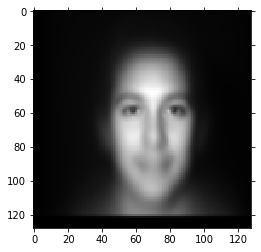

In [6]:
mean_face = np.zeros((1,height*width))

# Adding all the image vectors together
for i in training_tensor:
    mean_face = np.add(mean_face,i)

# Calculating the mean face vector
# Converting the mean_face row vector to a column vector
mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [7]:
pickledData = os.path.join('pickledData', 'mean_face.pickle')

## We now pickle the mean face data so that it does not need to be recalculated later.

In [8]:
with open(pickledData, 'wb') as pickleHandler:
    pickle.dump(mean_face, pickleHandler)

## We now load the mean face data from the pickle file we stored it in earlier

In [9]:
with open(pickledData, "rb") as pickleHandler:
    mean_face = pickle.load(pickleHandler)

## Normalised faces

In [10]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

# We now subtract the mean image from each and every image vector to get the normalised faces
for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)

### Display normalised faces

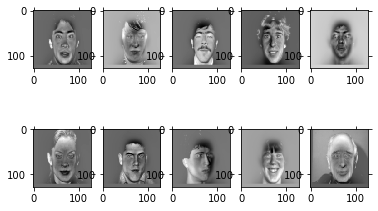

In [11]:
for i in range(10): #len(train_image_names)):
    img = normalised_training_tensor[i].reshape(height,width)
    plt.subplot(2,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Covariance matrix

By default, the cov() in the numpy module function will calculate the unbiased or sample covariance between the provided random variables.

The formula used is:
$$ S = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu)(x_i - \mu)^T $$
Where,<br>
*n* is the number of observations or training images in this case<br>
$x_i$ is a column vector containing the information about one particular data point/pixel from each of the training images<br>
$\mu$ is the column vector containing the mean image, which contains the average value for each and every pixel, taken across the training images


Also by the above description, we can understand that each row of the matrix ***X*** represents a <u>training image</u>

In [12]:
cov_matrix = np.cov(normalised_training_tensor)

# We divide by the number of images - 1
# cov_matrix = np.divide(cov_matrix, 7.0)
print(f'Covariance matrix of X: \n{cov_matrix}')

Covariance matrix of X: 
[[ 0.00815327 -0.0022356   0.002182   ... -0.00234935  0.00254038
  -0.00243302]
 [-0.0022356   0.00704963 -0.00371174 ...  0.00440758 -0.00431103
   0.00409453]
 [ 0.002182   -0.00371174  0.02363387 ...  0.0013396   0.00168899
  -0.0068594 ]
 ...
 [-0.00234935  0.00440758  0.0013396  ...  0.01560681 -0.00718359
   0.00194633]
 [ 0.00254038 -0.00431103  0.00168899 ... -0.00718359  0.0210038
  -0.00468062]
 [-0.00243302  0.00409453 -0.0068594  ...  0.00194633 -0.00468062
   0.00671399]]


In [13]:
pickledData = os.path.join('pickledData', 'cov_matrix.pickle')

## We now pickle the mean face data so that it does not need to be recalculated later.

In [14]:
with open(pickledData, 'wb') as pickleHandler:
    pickle.dump(cov_matrix, pickleHandler)

## We now load the mean face data from the pickle file we stored it in earlier

In [15]:
with open(pickledData, "rb") as pickleHandler:
    cov_matrix = pickle.load(pickleHandler)

In [16]:
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
print(f'Eigenvectors of Cov(X): \n{eigenvectors}')
print(f'\nEigenvalues of Cov(X): \n{eigenvalues}')

Eigenvectors of Cov(X): 
[[ 0.00808098+0.j -0.00247781+0.j  0.00885934+0.j ...  0.00226268+0.j
  -0.00517483+0.j -0.0007117 +0.j]
 [-0.01526197+0.j  0.00110942+0.j  0.00371112+0.j ...  0.02214213+0.j
   0.01295658+0.j -0.00411913+0.j]
 [ 0.0154645 +0.j -0.03389854+0.j  0.01358949+0.j ... -0.00263643+0.j
  -0.00784564+0.j -0.00451833+0.j]
 ...
 [-0.01693471+0.j -0.02197339+0.j -0.00163448+0.j ... -0.00461084+0.j
  -0.02622196+0.j -0.01382946+0.j]
 [ 0.02199948+0.j  0.01471736+0.j -0.01419627+0.j ... -0.00739455+0.j
  -0.01102565+0.j  0.01935854+0.j]
 [-0.01534614+0.j  0.01278433+0.j  0.00580327+0.j ...  0.00317651+0.j
  -0.01226915+0.j  0.0312621 +0.j]]

Eigenvalues of Cov(X): 
[1.61416466e+01+0.j 7.26964054e+00+0.j 3.83046601e+00+0.j ...
 6.15496871e-06+0.j 6.16579693e-06+0.j 5.80346917e-06+0.j]


In [17]:
pickledData_1 = os.path.join('pickledData', 'eigen_values.pickle')
pickledData_2 = os.path.join('pickledData', 'eigen_vectors.pickle')

## We now pickle the eigenvalues and eigenvectors so that it does not need to be recalculated later.

In [18]:
with open(pickledData_1, 'wb') as pickleHandler:
    pickle.dump(eigenvalues, pickleHandler)

with open(pickledData_2, 'wb') as pickleHandler:
    pickle.dump(eigenvectors, pickleHandler)

## We now load the eigenvalues and eigenvectors from the pickle file we stored it in earlier

In [19]:
with open(pickledData_1, "rb") as pickleHandler:
    eigenvalues = pickle.load(pickleHandler)

with open(pickledData_2, "rb") as pickleHandler:
    eigenvectors = pickle.load(pickleHandler)

## We now analyze the eigenvectors and corresponding eigenvalues  to pick the most relevant ones

In [20]:
# Grouped the eigenvalues and corresponding eigen vector together
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True, key= lambda x: x[0])

# We then again split the eigen values and eigen vectors into separate lists but in corresponding order
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

## Find cumulative variance of each principle component

To figure out the number of eigen vectors needed to form the basis eigen faces, we try to calculate how many eigenvalues we need (starting from the largest eigenvalue all the way to the lowest) such than we can minimize the loss in the details/data in the complete training face space, but still effeciently store the it as well.

Maximize the amount of details and minimize the amount of data stored.

Cumulative proportion of variance explained vector: 
[0.24441235+0.j 0.35448724+0.j 0.4124871 +0.j ... 1.        +0.j
 1.        +0.j 1.        +0.j]


/usr/lib/python3/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


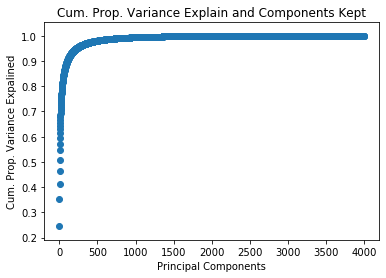

In [21]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

## Normalise the Eigen Vectors

In [22]:
ctr = 0
for i in eigvectors_sort:
    norm = np.linalg.norm(i)
    eigvectors_sort[ctr] = i/norm
    ctr += 1

## Choose the necessary no.of principle components:

We take the top 500 eigenvectors

In [23]:
reduced_data = np.array(eigvectors_sort[:500]).transpose()
print(reduced_data.shape)

(3993, 500)


We now project each of the images in our *training data set* onto the space represented by the **500 eigen vectors**, we selected earlier.

We now try to find the projected data. This will form the <u>eigen space</u>.

In [24]:
proj_data = np.dot(training_tensor.transpose(), reduced_data)
proj_data = proj_data.transpose()

In [25]:
pickledData = os.path.join('pickledData', 'projected_images.pickle')

## We now pickle the projected faces data so that it does not need to be recalculated later.

In [26]:
with open(pickledData, 'wb') as pickleHandler:
    pickle.dump(proj_data, pickleHandler)

## We now load the projected faces data from the pickle file we stored it in earlier

In [27]:
with open(pickledData, "rb") as pickleHandler:
    proj_data = pickle.load(pickleHandler)

## Plot eigen faces

- The **red** regions are the <u>darker regions</u> for the facial data, positive weights will increase the presence of these features

- The **blue** regions are the <u>lighter regions</u> for the facial data, negative weights will increase the presence of these features

(500, 16384)


<ipython-input-28-d4703aed4d36>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.astype('float64')


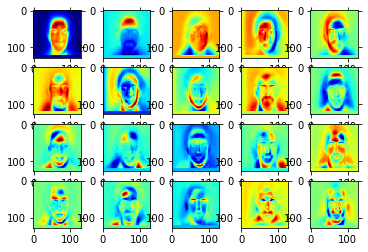

In [28]:
print(proj_data.shape)
for i in range(20): # proj_data.shape[0]):
    # temp = map(proj_data[i])
    a = copy.deepcopy(proj_data[i])
    
    new_row = map(complex, a)
    ctr_1 = 0
    for j in new_row:
        a[ctr_1] = float(j.real)
        ctr_1 += 1
    
    a = a.astype('float64') 
    # img = proj_data[i].reshape(height,width)
    img = a.reshape(height,width)
    # plt.subplot(2,4,1+i)
    plt.subplot(4,5,1+i)
    plt.imshow(img, cmap='jet')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Finding weights for each traning image

In [29]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
w

array([[ 2.14809505e+03+0.j, -2.93696980e+02+0.j,  5.52487600e+02+0.j,
        ...,  9.62956326e-01+0.j,  2.90685764e-01+0.j,
        -3.12235096e-01+0.j],
       [-6.52940201e+03+0.j, -1.84178096e+02+0.j,  1.01427663e+03+0.j,
        ..., -3.50890713e-01+0.j,  4.83937816e-01+0.j,
        -5.53816485e-01+0.j],
       [ 4.90044983e+03+0.j, -3.93439781e+03+0.j,  5.98684744e+02+0.j,
        ...,  2.94321637e-01+0.j, -1.26370449e+00+0.j,
         7.15780047e-01+0.j],
       ...,
       [-7.08674160e+03+0.j, -2.94789365e+03+0.j,  7.14849819e+02+0.j,
        ..., -1.16227108e+00+0.j,  6.28415373e-01+0.j,
        -1.01599834e+00+0.j],
       [ 8.38217399e+03+0.j,  2.07813731e+03+0.j, -1.69453200e+03+0.j,
        ...,  2.63199543e+00+0.j, -9.52949709e-01+0.j,
         2.78743257e+00+0.j],
       [-6.68165649e+03+0.j,  1.18979536e+03+0.j,  1.18630595e+03+0.j,
        ..., -1.03350602e+00+0.j, -4.02023957e-01+0.j,
        -1.37597385e+00+0.j]])

In [30]:
pickledData = os.path.join('pickledData', 'training_image_weights.pickle')

## We now pickle the weights data so that it does not need to be recalculated later.

In [31]:
with open(pickledData, 'wb') as pickleHandler:
    pickle.dump(w, pickleHandler)

## We now load the weights data from the pickle file we stored it in earlier

In [32]:
with open(pickledData, "rb") as pickleHandler:
    w = pickle.load(pickleHandler)

## We now stop the timer to note down the time taken

In [33]:
end = time.time()

## The amount of time taken for training is shown below

In [34]:
print(f"Training time = {end} - {start_time} = {end - start_time}")

Training time = 1590126218.7447693 - 1590124737.7509773 = 1480.9937920570374


## Now we now try recognizing a  random face from the dataset
- This is done to check to see if the two

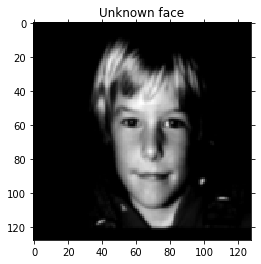

In [35]:
unknown_face        = plt.imread(os.path.join(dataset_path, '1227.png')) #'Dataset/subject12.normal.jpg')
unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()

plt.imshow(unknown_face, cmap='gray')
plt.title('Unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

### Normalise unknown face

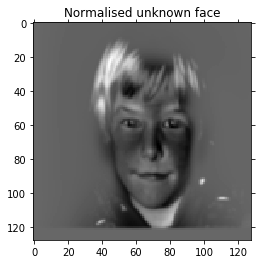

In [36]:
normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

plt.imshow(normalised_uface_vector.reshape(height, width), cmap='gray')
plt.title('Normalised unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

### Weights of uknown face

Projecting the normalized vector onto the eigenspace, to find out the weights:

In [37]:
w_unknown = np.dot(proj_data, unknown_face_vector)
w_unknown

array([ 1.26077046e+04+0.j,  3.55535531e+02+0.j, -7.98224826e+02+0.j,
        5.94380740e+02+0.j,  1.12059138e+03+0.j,  9.75458552e+02+0.j,
        2.06107834e+03+0.j, -2.28614592e+03+0.j,  2.06195555e+03+0.j,
       -1.17646254e+03+0.j,  2.94510151e+02+0.j,  1.00951796e+03+0.j,
        1.35065328e+02+0.j,  6.89176660e+02+0.j, -3.16997186e+02+0.j,
       -2.15571605e+02+0.j, -4.92351162e+00+0.j,  4.42238134e+02+0.j,
        1.04366186e+02+0.j,  5.80135168e+02+0.j,  5.72061800e+02+0.j,
        6.69466136e+02+0.j, -1.42385095e+02+0.j,  5.39673157e+02+0.j,
        1.24354911e+03+0.j,  2.07772593e+02+0.j, -1.99938860e+02+0.j,
        1.50399750e+02+0.j, -3.93888200e+01+0.j, -4.77594351e+02+0.j,
       -3.58923237e+02+0.j, -2.94420210e+02+0.j,  3.64017736e+02+0.j,
       -3.80177250e+02+0.j, -1.24569784e+02+0.j,  2.30941253e+02+0.j,
       -1.33113368e+00+0.j,  2.94944368e+02+0.j, -3.31002108e+01+0.j,
        9.67961497e+00+0.j, -2.18775304e+02+0.j,  4.05873191e+01+0.j,
        1.46930194e+

Finding the $min|W - W_{unknown}|$

In [38]:
diff  = w - w_unknown
norms = np.linalg.norm(diff, axis=1)
print(norms)
min(norms)

[11714.14952533 20827.07852521  9822.2551027  ... 21639.24514473
  5536.53502466 21087.64385485]


2487.9655840714095

## We now measure the time taken to recognize a set of testing images

In [39]:
start = time.time()

## Reconizing all test images

In [40]:
count        = 0
num_images   = 0
correct_pred = 0
def recogniser(img, train_image_names,proj_data,w):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread(os.path.join(dataset_path,img))
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(50, 2,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    t1 = 100111536
    #t1 = 200535910.268 # working with 6 faces
    #t0 = 86528212
    t0 = 88831687
    #t0 = 143559033 # working with 6 faces
    
    if norms[index] < t1:
        plt.subplot(50, 2,1+count)
        if norms[index] < t0: # It's a face
            if img.split('.')[0] == train_image_names[index].split('.')[0]:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
                plt.imshow(imread(os.path.join(dataset_path, train_image_names[index])), cmap='gray')
                
                correct_pred += 1
            else:
                plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
                plt.imshow(imread(os.path.join(dataset_path, train_image_names[index])), cmap='gray')
        else:
            if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
                plt.title('Unknown face!', color='g')
                correct_pred += 1
            else:
                plt.title('Unknown face!', color='r')
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
        plt.subplots_adjust(right=1.2, top=2.5)
    else:     
        plt.subplot(50, 2,1+count)
        if len(img.split('.')) == 3:
            plt.title('Not a face!', color='r')
        else:
            plt.title('Not a face!', color='g')
            correct_pred += 1
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1

fig = plt.figure(num=1,figsize=(200, 200))
for i in range(50): # len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,proj_data,w)

plt.show()

print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))

Correct predictions: 50/50 = 100.0%


## We now stop the timer to note down the time taken

In [41]:
end = time.time()

## The amount of time taken for testing is shown below

In [42]:
print(f"Testing time = {end} - {start} = {end - start}")

Testing time = 1590126258.5569682 - 1590126219.1923032 = 39.364665031433105


## Normalised images

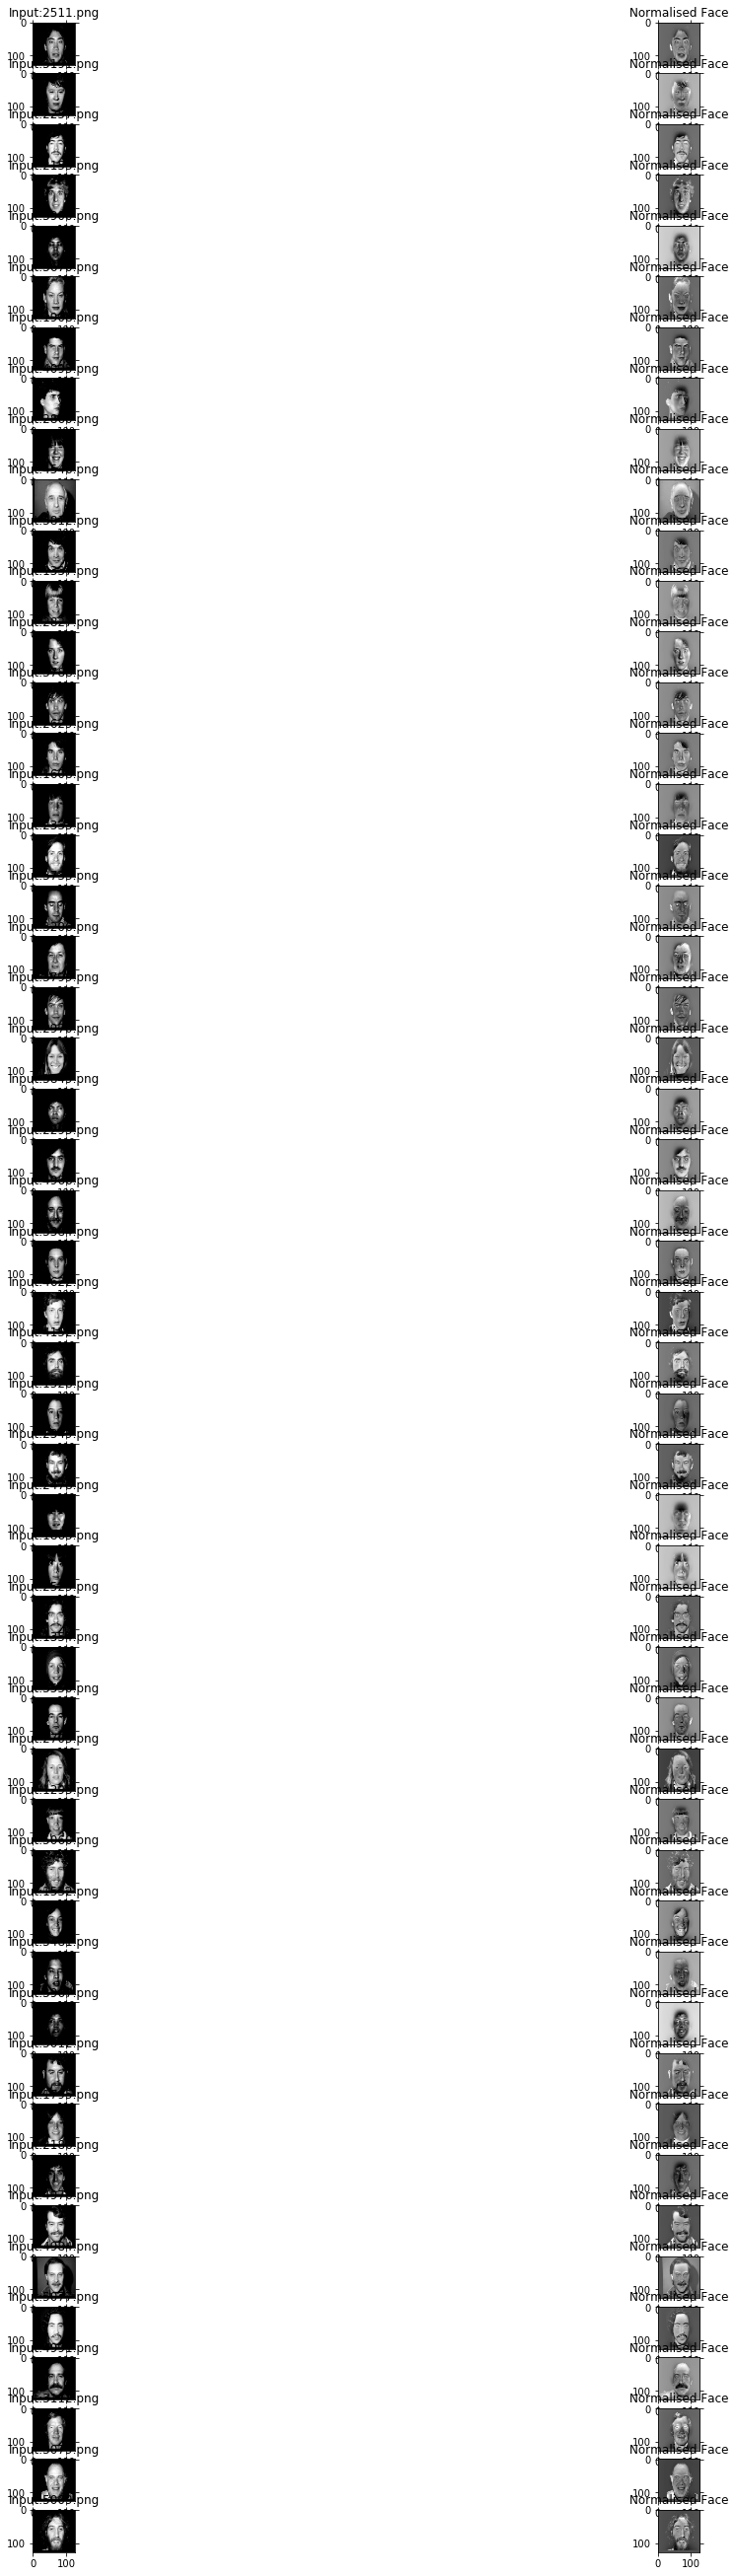

In [43]:
count        = 0
def recogniser(img, train_image_names,proj_data,w):
    global count
    unknown_face        = plt.imread(os.path.join(dataset_path,img))
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    # plt.subplot(9,4,1+count)
    plt.subplot(50, 2,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    # plt.subplot(9,4,1+count)
    plt.subplot(50, 2,1+count)
    plt.imshow(normalised_uface_vector.reshape(height, width), cmap='gray')
    plt.title('Normalised Face')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.subplots_adjust(right=1.2, top=2.5)
    count+=1

fig = plt.figure(figsize=(15, 15))
for i in range(50): #len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,proj_data,w)

plt.show()